# ResNet on CIFAR10

## Configuration

Imports

In [1]:
print()

In [2]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.utils import convert_tensor
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [3]:
DATA_DIR='./data'

NUM_CLASSES = 10
NUM_WORKERS = 20
BATCH_SIZE = 32
NUM_BA_COPIES = 4
EPOCHS = 200

In [4]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Data

Trivial Augment, [arXiv:2103.10158 [cs.CV]](https://arxiv.org/abs/2103.10158)

Random Erasing, [arXiv:1708.04896 [cs.CV]](https://arxiv.org/abs/1708.04896)

In [5]:
train_transform = transforms.Compose([
    transforms.TrivialAugmentWide(interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.RandomErasing(p=0.1)
])

In [6]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:03<00:00, 46420095.40it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Batch Augmentation, [arXiv:1901.09335 [cs.LG]](https://arxiv.org/abs/1901.09335)

In [7]:
class CollateFN:
    def __init__(self, transform, num_copies=1):
        self.transform = transform
        self.num_copies = num_copies
    
    def __call__(self, batch):
        images, labels = zip(*batch)
        
        transformed_images = [self.transform(img) for img in images for _ in range(self.num_copies)]
        new_labels = [lbl for lbl in labels for _ in range(self.num_copies)]
        X = torch.stack(transformed_images, dim=0)
        Y = torch.tensor(new_labels)
        return X, Y

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, ConcatDataset
import torchvision.transforms as tt

In [9]:
stats = ((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))
train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomCrop(32, padding=4, padding_mode="reflect"),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

In [10]:
train_data = CIFAR10(download=True, root="./data", transform=train_transform)
test_data = CIFAR10(root="./data", train=False, transform=test_transform)

Files already downloaded and verified


In [11]:
for image, label in train_data:
    print("Image shape: ",image.shape)
    print("Image tensor: ", image)
    print("Label: ", label)
    break

Image shape:  torch.Size([3, 32, 32])
Image tensor:  tensor([[[-0.1050, -0.1636, -0.1831,  ..., -0.8266, -0.5146, -0.2026],
         [-0.2806, -0.2416, -0.3001,  ..., -0.0855,  0.0120,  0.1095],
         [-0.3781, -0.0075,  0.0120,  ..., -0.2221,  0.0120,  0.2460],
         ...,
         [ 0.1095,  0.1875,  0.4605,  ...,  1.1625,  0.1095, -0.1636],
         [-0.1441,  0.0900,  0.2460,  ...,  1.6695,  0.8115,  0.0510],
         [ 0.0315, -0.0660,  0.1680,  ...,  1.4940,  1.4355,  0.2655]],

        [[-0.9297, -0.9297, -0.9100,  ..., -1.3245, -1.1271, -0.8903],
         [-1.0679, -0.9889, -1.0284,  ..., -0.7324, -0.6732, -0.6140],
         [-1.0284, -0.6337, -0.6140,  ..., -0.7916, -0.5942, -0.3771],
         ...,
         [-0.6732, -0.5942, -0.3179,  ...,  0.6886, -0.4363, -0.6337],
         [-0.9495, -0.7126, -0.5153,  ...,  1.1623,  0.1360, -0.6732],
         [-0.7126, -0.8311, -0.5942,  ...,  0.9649,  0.8465, -0.3377]],

        [[-1.4811, -1.4811, -1.4036,  ..., -1.6554, -1.5586, -1

In [12]:
train_classes_items = dict()

for train_item in train_data:
    label = train_data.classes[train_item[1]]
    if label not in train_classes_items:
        train_classes_items[label] = 1
    else:
        train_classes_items[label] += 1

train_classes_items

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

In [13]:
test_classes_items = dict()
for test_item in test_data:
    label = test_data.classes[test_item[1]]
    if label not in test_classes_items:
        test_classes_items[label] = 1
    else:
        test_classes_items[label] += 1

test_classes_items

{'cat': 1000,
 'ship': 1000,
 'airplane': 1000,
 'frog': 1000,
 'automobile': 1000,
 'truck': 1000,
 'dog': 1000,
 'horse': 1000,
 'deer': 1000,
 'bird': 1000}

In [14]:
BATCH_SIZE = 128
train_loader = DataLoader(train_data, BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_data, BATCH_SIZE, num_workers=4, pin_memory=True)

In [15]:
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()

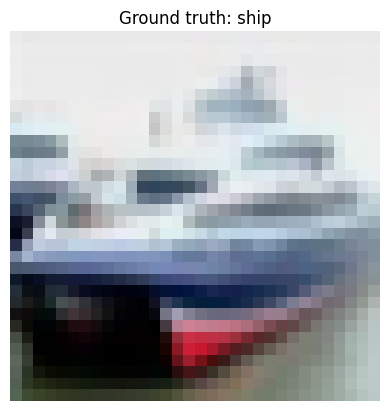

In [16]:
dataset_show_image(test_dset, 1)

## Model

Improvements of ResNet from [arXiv:1812.01187 [cs.CV]](https://arxiv.org/abs/1812.01187)

SiLU activation $x\cdot\sigma(x)$, [arXiv:1702.03118 [cs.LG]](https://arxiv.org/abs/1702.03118);
more general Swish activation $x\cdot\sigma(\beta x)$, [arXiv:1710.05941 [cs.NE]](https://arxiv.org/abs/1710.05941)

In [17]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, act=True):
        padding = (kernel_size - 1) // 2
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels)
        ]
        if act: layers.append(nn.SiLU(inplace=True))
        super().__init__(*layers)

In [18]:
class BasicResidual(nn.Sequential):
    def __init__(self, in_channels, out_channels, p_drop=0.):
        super().__init__(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels, act=False),
            nn.Dropout2d(p_drop)
        )

In [19]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, p_drop=0.):
        super().__init__()
        self.shortcut = self.get_shortcut(in_channels, out_channels)
        self.residual = BasicResidual(in_channels, out_channels, p_drop)
        self.act = nn.SiLU(inplace=True)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        out = self.shortcut(x) + self.gamma * self.residual(x)
        return self.act(out)
    
    def get_shortcut(self, in_channels, out_channels):
        if in_channels != out_channels:
            shortcut = ConvBlock(in_channels, out_channels, 1, act=False)
        else:
            shortcut = nn.Identity()
        return shortcut

In [20]:
class ResidualStack(nn.Sequential):
    def __init__(self, in_channels, repetitions, strides, p_drop=0.):
        layers = []
        out_channels = in_channels
        for rep, stride in zip(repetitions, strides):
            if stride > 1: layers.append(nn.MaxPool2d(stride))
            for _ in range(rep):
                layers.append(ResidualBlock(in_channels, out_channels, p_drop))
                in_channels = out_channels
            out_channels *= 2
        super().__init__(*layers)

In [21]:
class Stem(nn.Sequential):
    def __init__(self, in_channels, channel_list, stride):
        layers = []
        for out_channels in channel_list:
            layers.append(ConvBlock(in_channels, out_channels, 3, stride=stride))
            in_channels = out_channels
            stride = 1
        super().__init__(*layers)

In [22]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes, p_drop=0.):
        super().__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(in_channels, classes)
        )

In [23]:
class ResNet(nn.Sequential):
    def __init__(self, classes, repetitions, strides=None, in_channels=3, res_p_drop=0., head_p_drop=0.):
        if strides is None: strides = [2] * (len(repetitions) + 1)
        super().__init__(
            Stem(in_channels, [32, 32, 64], strides[0]),
            ResidualStack(64, repetitions, strides[1:], res_p_drop),
            Head(64 * 2**(len(repetitions) - 1), classes, head_p_drop)
        )

In [24]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [25]:
model = ResNet(NUM_CLASSES, [2, 2, 2, 2], strides=[1, 1, 2, 2, 2], res_p_drop=0., head_p_drop=0.3)

In [26]:
model.apply(init_linear);

In [27]:
model.to(DEVICE);

In [28]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 11,200,882


## Loss

In [29]:
def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

Label smoothing introduced in [arXiv:1512.00567 [cs.CV]](https://arxiv.org/abs/1512.00567)

In [30]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε=0.1, reduction='mean'):
        super().__init__()
        self.ε = ε
        self.reduction = reduction

    def forward(self, output, target):
        c = output.size(-1)
        log_preds = F.log_softmax(output, dim=-1)
        loss1 = reduce_loss(-log_preds.sum(dim=-1) / c, self.reduction)
        loss2 = F.nll_loss(log_preds, target, reduction=self.reduction)
        loss = (1. - self.ε) * loss2 + self.ε * loss1
        return loss

## CutMix

CutMix, [arXiv:1905.04899 [cs.CV]](https://arxiv.org/abs/1905.04899)

In [31]:
class CutMix(nn.Module):
    def __init__(self, loss, α=1.0):
        super().__init__()
        self.loss = loss
        self.α = α
        self.rng = np.random.default_rng()
    
    def prepare_batch(self, batch, device, non_blocking):
        x, y = batch
        x = convert_tensor(x, device=device, non_blocking=non_blocking)
        y = convert_tensor(y, device=device, non_blocking=non_blocking)
        
        batch_size = x.size(0)
        self.index = torch.randperm(batch_size).to(device)
        
        self.λ = self.rng.beta(self.α, self.α)
        y1, x1, y2, x2 = self.cut_bounding_box(x.shape[-2:], self.λ)
        x[:, :, y1:y2, x1:x2] = x[self.index, :, y1:y2, x1:x2]
                
        # adjust lambda to exactly match pixel ratio
        area = x.size(2) * x.size(3)
        self.λ = 1. - (x2 - x1) * (y2 - y1) / area
        return x, y
    
    def cut_bounding_box(self, shape, λ):
        cut_size_2 = 0.5 * np.sqrt(1. - λ)
        center_yx = self.rng.random(2)
        
        y1x1 = (np.clip(center_yx - cut_size_2, 0., 1.) * shape).astype(int)
        y2x2 = (np.clip(center_yx + cut_size_2, 0., 1.) * shape).astype(int)
        return np.concatenate((y1x1, y2x2))
        
    def forward(self, pred, target):
        orig_reduction = self.loss.reduction
        self.loss.reduction = 'none'
        batch_loss = self.λ * self.loss(pred, target) + (1. - self.λ) * self.loss(pred, target[self.index])
        self.loss.reduction = orig_reduction
        return reduce_loss(batch_loss, orig_reduction)

## Lookahead optimizer

Lookahead optimizer, [arXiv:1907.08610 [cs.LG]](https://arxiv.org/abs/1907.08610)

Code from https://github.com/alphadl/lookahead.pytorch

In [32]:
class Lookahead(optim.Optimizer):
    def __init__(self, optimizer, k=5, alpha=0.5):
        self.optimizer = optimizer
        self.k = k
        self.alpha = alpha
        self.param_groups = self.optimizer.param_groups
        self.defaults = self.optimizer.defaults
        self.state = defaultdict(dict)
        self.fast_state = self.optimizer.state
        for group in self.param_groups:
            group["counter"] = 0

        # Add missing attributes
        self._step_count = 0
        self._optimizer_step_pre_hooks = self.optimizer._optimizer_step_pre_hooks
        self._optimizer_step_post_hooks = self.optimizer._optimizer_step_post_hooks

    def __getstate__(self):
        return {
            'optimizer': self.optimizer,
            'k': self.k,
            'alpha': self.alpha,
            'param_groups': self.param_groups,
            'defaults': self.defaults,
            'state': self.state,
            'fast_state': self.fast_state,
            '_step_count': self._step_count,
            '_optimizer_step_pre_hooks': self._optimizer_step_pre_hooks,
            '_optimizer_step_post_hooks': self._optimizer_step_post_hooks,
        }

    def __setstate__(self, state):
        self.__dict__.update(state)
    
    def update(self, group):
        for fast in group["params"]:
            param_state = self.state[fast]
            if "slow_param" not in param_state:
                param_state["slow_param"] = torch.zeros_like(fast.data)
                param_state["slow_param"].copy_(fast.data)
            slow = param_state["slow_param"]
            slow += (fast.data - slow) * self.alpha
            fast.data.copy_(slow)
    
    def update_lookahead(self):
        for group in self.param_groups:
            self.update(group)

    def step(self, closure=None):
        loss = self.optimizer.step(closure)
        for group in self.param_groups:
            if group["counter"] == 0:
                self.update(group)
            group["counter"] += 1
            if group["counter"] >= self.k:
                group["counter"] = 0
        return loss

    def state_dict(self):
        fast_state_dict = self.optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        fast_state = fast_state_dict["state"]
        param_groups = fast_state_dict["param_groups"]
        return {
            "fast_state": fast_state,
            "slow_state": slow_state,
            "param_groups": param_groups,
        }

    def load_state_dict(self, state_dict):
        slow_state_dict = {
            "state": state_dict["slow_state"],
            "param_groups": state_dict["param_groups"],
        }
        fast_state_dict = {
            "state": state_dict["fast_state"],
            "param_groups": state_dict["param_groups"],
        }
        super().load_state_dict(slow_state_dict)
        self.optimizer.load_state_dict(fast_state_dict)
        self.fast_state = self.optimizer.state

    def add_param_group(self, param_group):
        param_group["counter"] = 0
        self.optimizer.add_param_group(param_group)

## Training

### History

In [33]:
class History:
    def __init__(self):
        self.values = defaultdict(list)

    def append(self, key, value):
        self.values[key].append(value)

    def reset(self):
        for k in self.values.keys():
            self.values[k] = []

    def _begin_plot(self):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111)

    def _end_plot(self, ylabel):
        self.ax.set_xlabel('epoch')
        self.ax.set_ylabel(ylabel)
        plt.show()

    def _plot(self, key, line_type='-', label=None):
        if label is None: label=key
        xs = np.arange(1, len(self.values[key])+1)
        self.ax.plot(xs, self.values[key], line_type, label=label)

    def plot(self, key):
        self._begin_plot()
        self._plot(key, '-')
        self._end_plot(key)

    def plot_train_val(self, key):
        self._begin_plot()
        self._plot('train ' + key, '.-', 'train')
        self._plot('val ' + key, '.-', 'val')
        self.ax.legend()
        self._end_plot(key)

### Trainer Setup

In [34]:
loss = LabelSmoothingCrossEntropy()

In [35]:
cutmix = CutMix(loss, α=1.0)

AdamW optimizer, [arXiv:1711.05101 [cs.LG]](https://arxiv.org/abs/1711.05101)

In [36]:
base_optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-2)

In [37]:
optimizer = Lookahead(base_optimizer, k=5, alpha=0.5)

In [38]:
trainer = create_supervised_trainer(model, optimizer, cutmix, device=DEVICE, prepare_batch=cutmix.prepare_batch)

"1cycle" leraning rate policy, [arXiv:1803.09820 [cs.LG]](https://arxiv.org/abs/1803.09820)

In [39]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(base_optimizer, max_lr=1e-2,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [40]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [41]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

In [42]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [43]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [44]:
history = History()

In [45]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history.append('train loss', train_loss)
    
    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history.append('val loss', val_loss)
    history.append('val acc', val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

### Training

In [46]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/200 - train: loss 1.944; val: loss 1.551 accuracy 0.531
2/200 - train: loss 1.832; val: loss 1.353 accuracy 0.630
3/200 - train: loss 1.775; val: loss 1.250 accuracy 0.673
4/200 - train: loss 1.714; val: loss 1.180 accuracy 0.714
5/200 - train: loss 1.674; val: loss 1.112 accuracy 0.740
6/200 - train: loss 1.629; val: loss 1.049 accuracy 0.773
7/200 - train: loss 1.594; val: loss 1.019 accuracy 0.789
8/200 - train: loss 1.571; val: loss 0.978 accuracy 0.806
9/200 - train: loss 1.549; val: loss 0.987 accuracy 0.802
10/200 - train: loss 1.532; val: loss 0.986 accuracy 0.812
11/200 - train: loss 1.501; val: loss 0.922 accuracy 0.839
12/200 - train: loss 1.477; val: loss 0.909 accuracy 0.839
13/200 - train: loss 1.453; val: loss 0.894 accuracy 0.858
14/200 - train: loss 1.445; val: loss 0.905 accuracy 0.849
15/200 - train: loss 1.446; val: loss 0.954 accuracy 0.827
16/200 - train: loss 1.416; val: loss 0.840 accuracy 0.875
17/200 - train: loss 1.407; val: loss 0.842 accuracy 0.875
18/200

KeyboardInterrupt: 

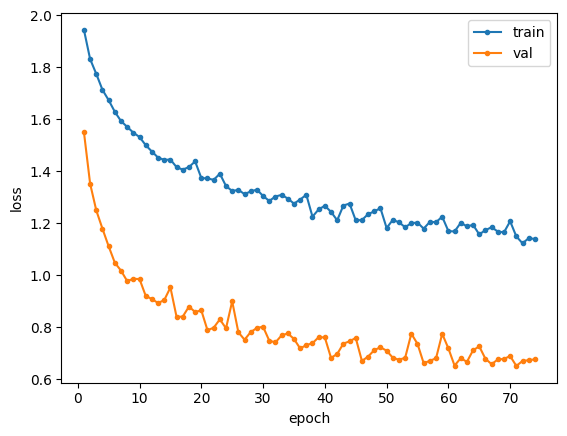

In [47]:
history.plot_train_val('loss')

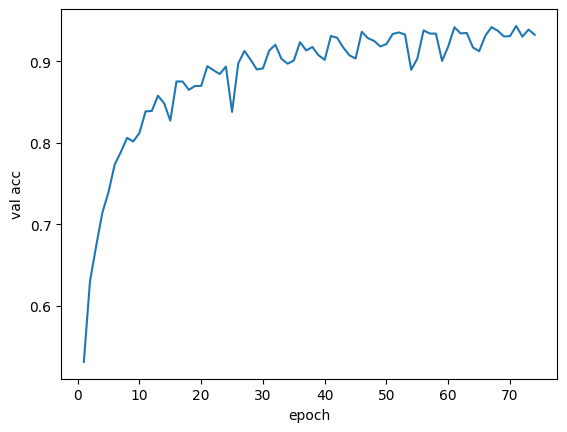

In [48]:
history.plot('val acc')